<a href="https://colab.research.google.com/github/BZ6/PINDeepLearning/blob/lab3/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%963.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этой лабораторной работе вы будете использовать рекуррентные нейронные сети.

In [ ]:
!pip install tensorflow opendatasets

In [88]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Dropout, LSTM
from tensorflow.keras.utils import to_categorical

https://www.kaggle.com/datasets/shayanfazeli/heartbeat - набор данных ЭКГ. Используйте мультиклассовый датасет.
https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products/data - отзывы клиентов Амазона. В качестве лейблов используйте оценки клиентов.

Для начала - задача классификации ЭКГ. Импортируйте датасет, подготовьте выборку, постройте и обучите модель, протестируйте её и в виде гистограмм проиллюстрируйте, в каких классах чаще ошибается нейронная сеть. Также для каждого класса постройте отдельную гистограмму, содержащую ложно классифицированные данные по разным классам.

In [70]:
od.download('https://www.kaggle.com/datasets/shayanfazeli/heartbeat')

train_data = pd.read_csv('heartbeat/mitbih_train.csv', header=None)
test_data = pd.read_csv('heartbeat/mitbih_test.csv', header=None)
ptbdb_normal = pd.read_csv('heartbeat/ptbdb_normal.csv', header=None)
ptbdb_abnormal = pd.read_csv('heartbeat/ptbdb_abnormal.csv', header=None)

Skipping, found downloaded files in "./heartbeat" (use force=True to force download)


In [71]:
train_data.head(500)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.963801,0.914027,0.619910,0.316742,0.242081,0.199095,0.117647,0.079186,0.099548,0.099548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.973046,0.822102,0.134771,0.142857,0.075472,0.102426,0.021563,0.048518,0.059299,0.086253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.900958,0.894569,0.305112,0.000000,0.250799,0.332268,0.289137,0.285942,0.292332,0.290735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.973225,0.816065,0.369034,0.000000,0.190920,0.181607,0.130384,0.138533,0.140861,0.138533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
class_labels = train_data[187].unique()
class_labels

array([0., 1., 2., 3., 4.])

In [73]:
class_names = {
    0: 'N',
    1: 'S',
    2: 'V',
    3: 'F',
    4: 'Q'
}

for label in class_labels:
    print(f"{label}: {class_names[label]}")

0.0: N
1.0: S
2.0: V
3.0: F
4.0: Q


In [74]:
def upsample(df, label, n_samples):
    df_t = df[df[187] == label]
    return resample(df_t, n_samples=n_samples, replace=True, random_state=123)

In [75]:
df_0_upsample = upsample(train_data, 0, 20000)
df_1_upsample = upsample(train_data, 1, 20000)
df_2_upsample = upsample(train_data, 2, 20000)
df_3_upsample = upsample(train_data, 3, 20000)
df_4_upsample = upsample(train_data, 4, 20000)

train_df = pd.concat([df_0_upsample, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

train_df[187].value_counts()

,count
187,
0.0,20000
1.0,20000
2.0,20000
3.0,20000
4.0,20000


In [76]:
df_0_upsample = upsample(test_data, 0, 5000)
df_1_upsample = upsample(test_data, 1, 5000)
df_2_upsample = upsample(test_data, 2, 5000)
df_3_upsample = upsample(test_data, 3, 5000)
df_4_upsample = upsample(test_data, 4, 5000)

test_df = pd.concat([df_0_upsample, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

test_df[187].value_counts()

,count
187,
0.0,5000
1.0,5000
2.0,5000
3.0,5000
4.0,5000


In [79]:
X_train = train_df.drop(columns=[187])
y_train = train_df[187]
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
15725,1.000000,0.856522,0.365217,0.130435,0.121739,0.130435,0.082609,0.073913,0.060870,0.060870,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28030,1.000000,0.732704,0.238994,0.069182,0.128931,0.097484,0.069182,0.047170,0.047170,0.025157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17730,1.000000,0.959799,0.733668,0.467337,0.221106,0.080402,0.065327,0.090452,0.090452,0.075377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61404,1.000000,0.946009,0.565728,0.201878,0.234742,0.260563,0.260563,0.237089,0.244131,0.237089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63206,0.000000,0.153125,0.293750,0.375000,0.412500,0.406250,0.425000,0.431250,0.412500,0.431250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86326,0.979769,0.765896,0.820809,0.274566,0.170520,0.150289,0.150289,0.147399,0.135838,0.130058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87200,0.701493,0.611940,0.510448,0.400000,0.282090,0.167164,0.092537,0.046269,0.050746,0.071642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83385,0.984660,0.934803,0.875360,0.802493,0.705657,0.593480,0.468840,0.371045,0.291467,0.220518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87507,0.925434,0.875383,0.812053,0.749745,0.660878,0.577120,0.451481,0.347293,0.241062,0.199183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test = test_df.drop(columns=[187])
y_test = test_df[187]

scaler = StandardScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)
X_test_normalized = scaler.transform(X_test)

In [95]:
model = Sequential([
    Input(shape=(187,1)),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_RNN = model.fit(X_train_normalized.reshape(-1, 187, 1), y_train, epochs=50, batch_size=128, validation_data=(X_valid_normalized, y_valid))

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4290 - loss: 1.3214 - val_accuracy: 0.5608 - val_loss: 1.1206
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5862 - loss: 1.0567 - val_accuracy: 0.6842 - val_loss: 0.8431
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6732 - loss: 0.8791 - val_accuracy: 0.6525 - val_loss: 0.8847
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6856 - loss: 0.8534 - val_accuracy: 0.7473 - val_loss: 0.7087
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6148 - loss: 0.9925 - val_accuracy: 0.6658 - val_loss: 0.8931
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6759 - loss: 0.8883 - val_accuracy: 0.7163 - val_loss: 0.7839
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7007 - loss: 0.8203 - val_accuracy: 0.6802 - val_loss: 0.8523
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6736 - loss: 0.8730 - va

In [96]:
loss, accuracy = model.evaluate(X_valid_normalized, y_valid)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9365 - loss: 0.1873
Validation Loss: 0.18169960379600525
Validation Accuracy: 0.9378125071525574


In [97]:
def show_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

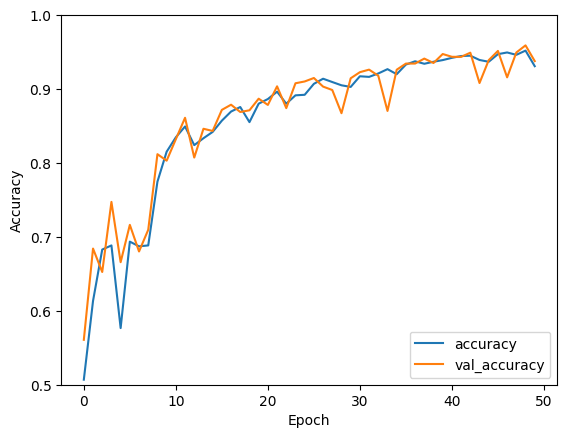

In [98]:
show_history(history_RNN)

In [106]:
y_pred = model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


In [112]:
y_test.values

array([0., 0., 0., ..., 4., 4., 4.])

In [108]:
y_pred_classes

array([0, 0, 0, ..., 4, 4, 4])

In [102]:
def plot_error_histogram(y_true, y_pred, classes):
    error_indices = np.where(y_true != y_pred)[0]

    error_counts = np.bincount(y_true[error_indices], minlength=len(classes))

    plt.figure(figsize=(10, 6))
    plt.bar(classes, error_counts, color='red')
    plt.title('Classes where the model makes more errors')
    plt.xlabel('True class')
    plt.ylabel('Number of errors')
    plt.show()

def plot_histograms(y_true, y_pred, classes):
    for i, class_name in enumerate(classes):
        true_indices = np.where(y_true == i)[0]
        false_indices = true_indices[np.where(y_pred[true_indices] != i)]

        false_counts = np.bincount(y_pred[false_indices], minlength=len(classes))

        plt.figure(figsize=(8, 6))
        plt.bar(classes, false_counts, color='blue')
        plt.title(f'False classifications for class {class_name}')
        plt.xlabel('Predicted class')
        plt.ylabel('Count')
        plt.show()

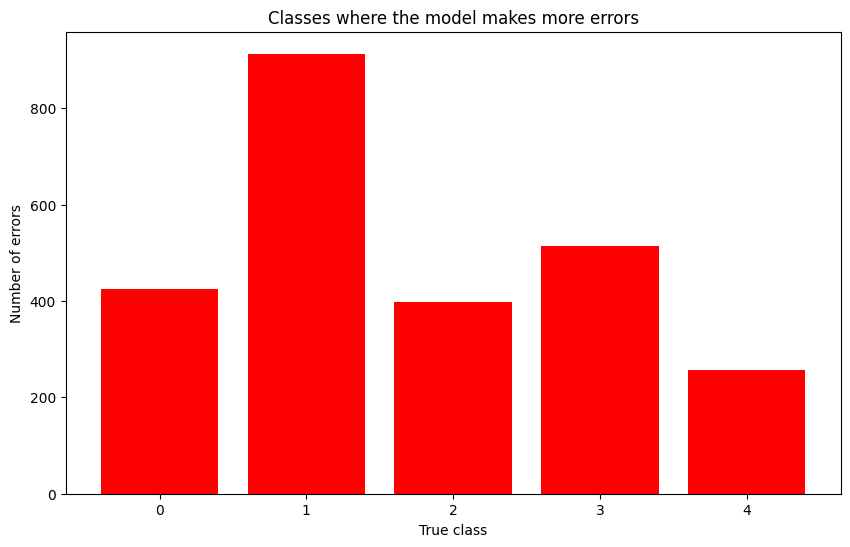

In [116]:
plot_error_histogram(y_test.values.astype(int), y_pred_classes, class_labels)

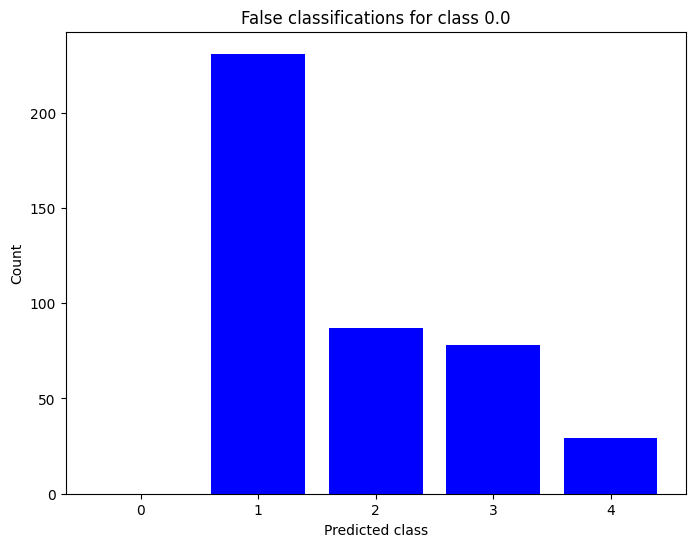

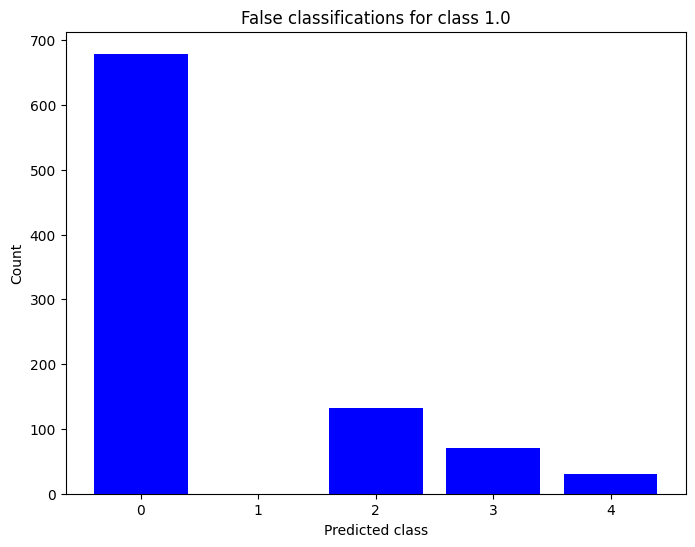

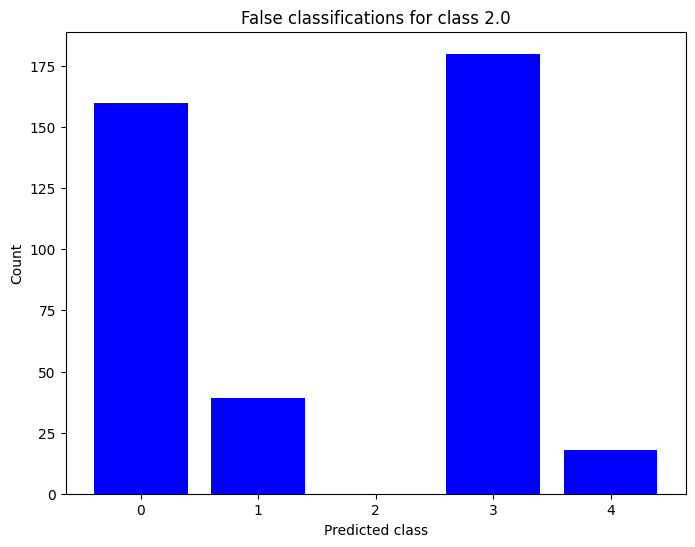

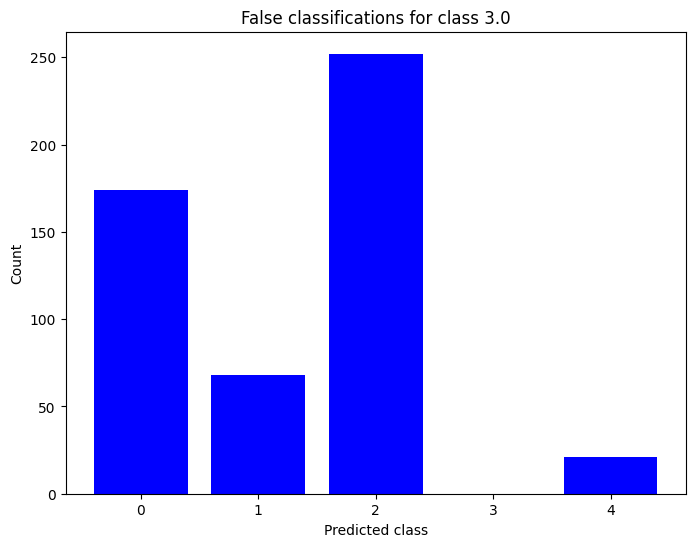

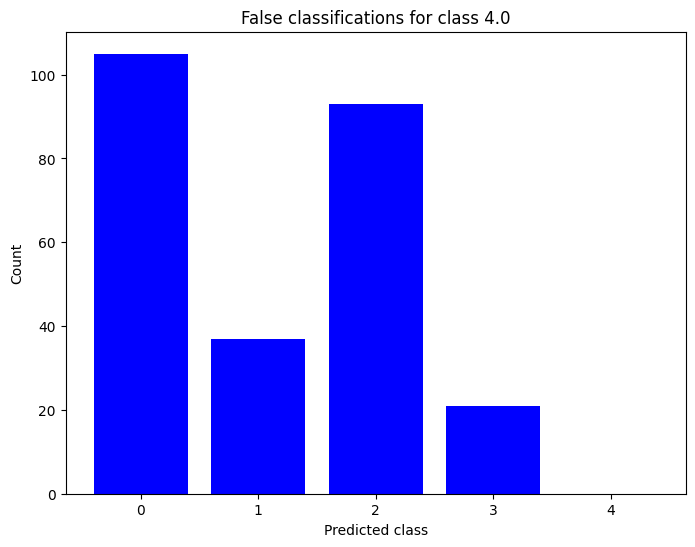

In [117]:
plot_histograms(y_test.values.astype(int), y_pred_classes, class_labels)

В задаче обработки текста в качестве входных данных используйте отзывы клиентов, в качестве выходных - их оценки. Получите точность не ниже 90%. Текст необходимо подготовить. Также подготовьте второй датасет, но к нему примените лемматизацию (например, из nltk) текста. При прочих равных параметрах сравните результаты модели, обученной с помощью обычного словаря и с помощью лемматизированного.